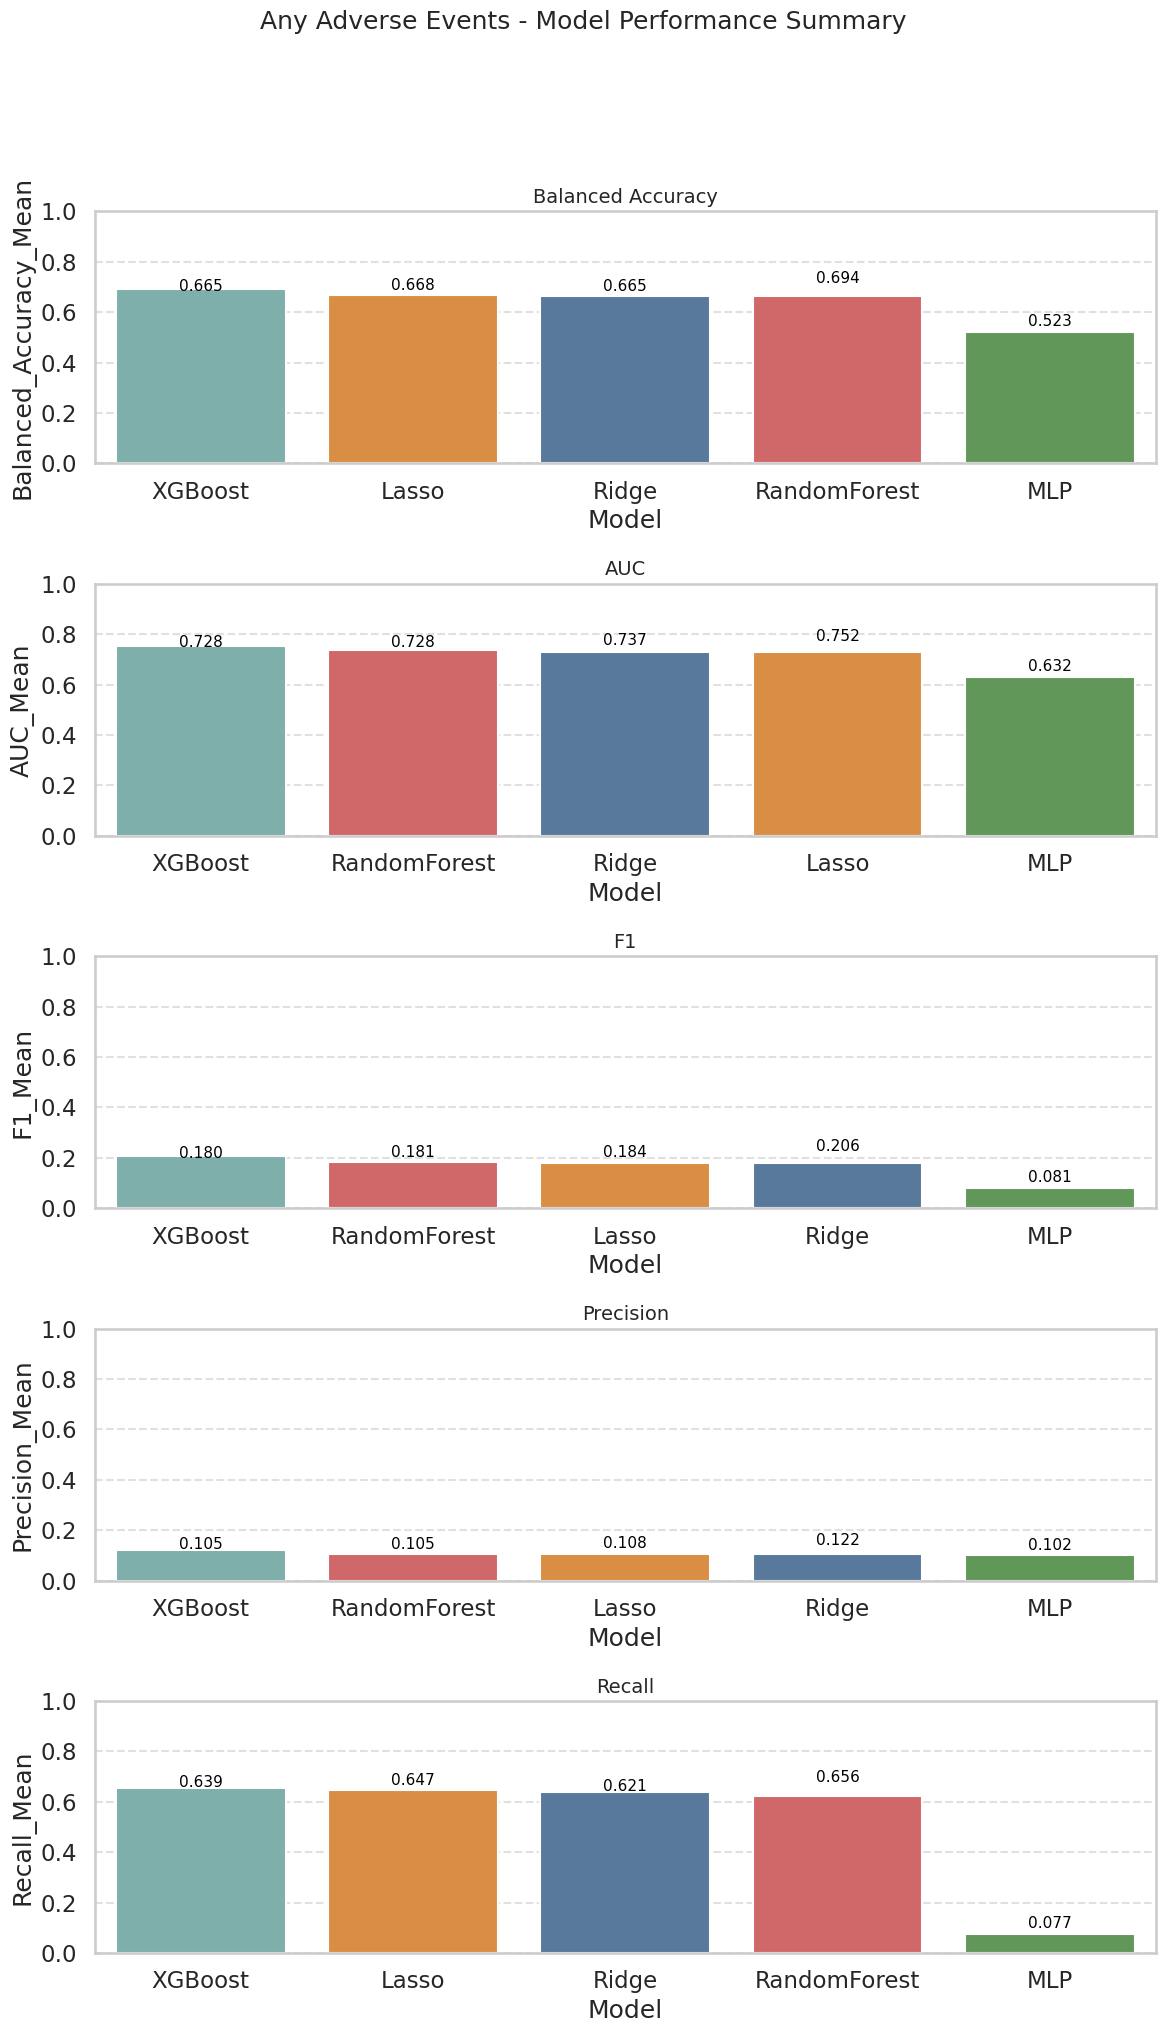

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv('/rds/general/user/hsl121/home/hda_project/adverse/results/any_adverse_binary/any_adverse_binary_results.csv')
df['Model'] = df['Model'].replace({'XGB': 'XGBoost'})

# === Melt data for seaborn lineplot ===
metrics = ['Balanced_Accuracy_Mean', 'AUC_Mean', 'F1_Mean', 'Precision_Mean', 'Recall_Mean']
df_long = df.melt(id_vars='Model', value_vars=metrics, var_name='Metric', value_name='Score')


# === Setup seaborn style ===
palette = {
    'Ridge': '#4e79a7',
    'Lasso': '#f28e2b',
    'RandomForest': '#e15759',
    'XGBoost': '#76b7b2',
    'MLP': '#59a14f'
}

sns.set(style='whitegrid', context='talk', palette='colorblind')

# === Facet-style plot (one subplot per metric) ===
fig, axes = plt.subplots(nrows=len(metrics), ncols=1, figsize=(12, 20), sharex=False)

for i, metric in enumerate(metrics):
    ax = axes[i]
    plot_df = df[['Model', metric]].copy().sort_values(metric, ascending=False)
    sns.barplot(data=plot_df, x='Model', y=metric, ax=ax, palette=palette, hue='Model')

    for idx, row in plot_df.iterrows():
        ax.text(x=idx, y=row[metric] + 0.009, s=f"{row[metric]:.3f}",
                ha='center', va='bottom', fontsize=11, color='black')

    ax.set_title(metric.replace('_Mean', '').replace('_', ' '), fontsize=14)
    ax.set_ylabel(metric)
    ax.set_ylim(0, 1)
    ax.grid(axis='y', linestyle='--', alpha=0.6)

axes[-1].set_xlabel("Model")
plt.suptitle("Any Adverse Events - Model Performance Summary", fontsize=18, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.97])

# === Save or show ===
plt.show()

/rds/general/ephemeral/user/hsl121/ephemeral/ipykernel_3636726/556673415.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=11)


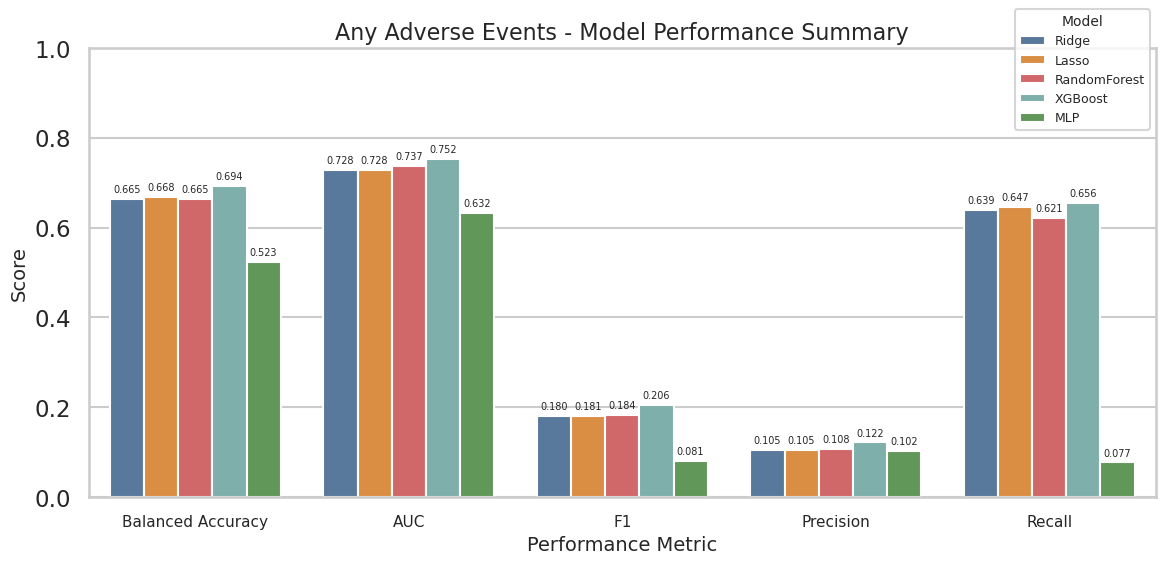

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# === Load and fix model names ===
df = pd.read_csv('/rds/general/user/hsl121/home/hda_project/adverse/results/any_adverse_binary/any_adverse_binary_results.csv')
df['Model'] = df['Model'].replace({'XGB': 'XGBoost'})

# === Melt the dataframe ===
metrics = ['Balanced_Accuracy_Mean', 'AUC_Mean', 'F1_Mean', 'Precision_Mean', 'Recall_Mean']
df_long = df.melt(id_vars='Model', value_vars=metrics, var_name='Metric', value_name='Score')

# Clean up metric names for nicer display
df_long['Metric'] = df_long['Metric'].str.replace('_Mean', '').str.replace('_', ' ')

# === Define consistent color palette ===
palette = {
    'Ridge': '#4e79a7',
    'Lasso': '#f28e2b',
    'RandomForest': '#e15759',
    'XGBoost': '#76b7b2',
    'MLP': '#59a14f'
}

# === Plot ===
sns.set(style='whitegrid', context='talk')
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_long, x='Metric', y='Score', hue='Model', palette=palette)

# Add text labels on top of bars
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height) and height > 0.02:
        ax.text(p.get_x() + p.get_width() / 2., height + 0.01, f'{height:.3f}',
                ha="center", va="bottom", fontsize=7)

# Customize axes and legend
ax.set_ylim(0, 1)
ax.set_ylabel("Score", fontsize=14)
ax.set_xlabel("Performance Metric", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11)
ax.legend(title='Model', fontsize=9, title_fontsize=10, loc='upper right', bbox_to_anchor=(1, 1.1))

# Final touches
plt.title("Any Adverse Events - Model Performance Summary", fontsize=16)
plt.savefig('/rds/general/user/hsl121/home/hda_project/adverse/results/any_adverse_binary/any_adverse_binary_summary_plot.png', dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()




In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import ast

# === Load saved CSV ===
df = pd.read_csv('/rds/general/user/hsl121/home/hda_project/adverse/results/severe_adverse_binary/severe_adverse_binary_results.csv')
df['Model'] = df['Model'].replace({'XGB': 'XGBoost'})

# === Extract usable metrics from stringified fold data ===
results = []
for _, row in df.iterrows():
    model = row['Model']
    try:
        fold_scores = ast.literal_eval(row['Per_Fold_Scores'])
    except Exception as e:
        print(f"Error parsing Per_Fold_Scores for {model}: {e}")
        continue
    results.append({'Model': model, 'Per_Fold_Scores': fold_scores})

# === Setup color palette ===
palette = {
    'Ridge': '#4e79a7',
    'Lasso': '#f28e2b',
    'RandomForest': '#e15759',
    'XGBoost': '#76b7b2',
    'MLP': '#59a14f'
}

# === Only use metrics you actually saved ===
metric_names = ['balanced_accuracy', 'auc']
plot_data = []

for res in results:
    model = res['Model']
    for metric in metric_names:
        values = res['Per_Fold_Scores'].get(metric, [])
        if not values:
            continue
        plot_data.append({
            'Model': model,
            'Metric': metric.replace('_', ' ').title(),
            'Mean': np.mean(values),
            'Std': np.std(values)
        })

df_plot = pd.DataFrame(plot_data)

# === Plot ===
sns.set(style='whitegrid', context='talk')
plt.figure(figsize=(12, 6))
ax = sns.barplot(data=df_plot, x='Metric', y='Mean', hue='Model', palette=palette, capsize=0.1)

# === Add error bars and labels ===
for i, bar in enumerate(ax.patches):
    height = bar.get_height()
    std = df_plot.iloc[i]['Std']
    if not np.isnan(std):
        ax.errorbar(bar.get_x() + bar.get_width()/2., height, yerr=std,
                    fmt='none', c='black', capsize=5, lw=1)
    if height > 0.02:
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=7)

# === Final touches ===
ax.set_ylim(0, 1)
ax.set_ylabel("Score", fontsize=14)
ax.set_xlabel("Performance Metric", fontsize=14)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=11)
ax.legend(title='Model', fontsize=10, title_fontsize=11, loc='upper right', bbox_to_anchor=(1, 1.09))
plt.title("Severe Adverse Events – Model Performance Summary with Error Bars", fontsize=16)
plt.tight_layout()
plt.show()


Error parsing Per_Fold_Scores for Ridge: malformed node or string: <ast.Call object at 0x1463a2a82df0>
Error parsing Per_Fold_Scores for Lasso: malformed node or string: <ast.Call object at 0x1463a2c738e0>
Error parsing Per_Fold_Scores for RandomForest: malformed node or string: <ast.Call object at 0x1463a2a85be0>
Error parsing Per_Fold_Scores for XGBoost: malformed node or string: <ast.Call object at 0x1463a2d03c40>
Error parsing Per_Fold_Scores for MLP: malformed node or string: <ast.Call object at 0x1463a2a85910>


ValueError: Could not interpret value `Metric` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

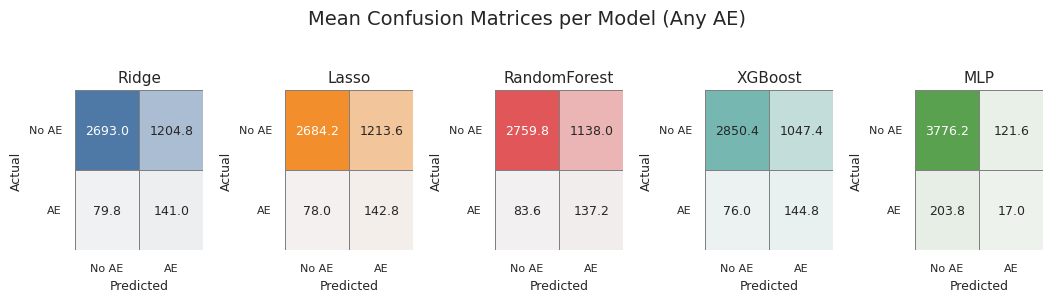

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Load and clean
df = pd.read_csv('/rds/general/user/hsl121/home/hda_project/adverse/results/any_adverse_binary/any_adverse_binary_results.csv')
df['Model'] = df['Model'].replace({'XGB': 'XGBoost'})

# Color palette
palette = {
    'Ridge': '#4e79a7',
    'Lasso': '#f28e2b',
    'RandomForest': '#e15759',
    'XGBoost': '#76b7b2',
    'MLP': '#59a14f'
}

# Style
sns.set(style='white', context='notebook')

# Create horizontal layout
n_models = len(df)
fig, axes = plt.subplots(nrows=1, ncols=n_models, figsize=(2.1 * n_models, 2.8), dpi=100)

for i, row in df.iterrows():
    model = row['Model']
    
    numbers = re.findall(r"\d+\.\d+|\d+", row['Mean_Confusion_Matrix'])
    numbers = list(map(float, numbers))
    matrix = np.array(numbers).reshape(2, 2)

    ax = axes[i]
    cmap = sns.light_palette(palette[model], as_cmap=True)

    sns.heatmap(
        matrix,
        annot=True,
        fmt='.1f',
        cmap=cmap,
        cbar=False,
        linewidths=0.4,
        linecolor='gray',
        annot_kws={"size": 9},
        xticklabels=['No AE', 'AE'],
        yticklabels=['No AE', 'AE'],
        ax=ax
    )

    ax.set_title(model, fontsize=11, pad=6)
    ax.set_xlabel("Predicted", fontsize=9)
    ax.set_ylabel("Actual", fontsize=9)
    ax.tick_params(labelsize=8)
    ax.set_xticklabels(['No AE', 'AE'], fontsize=8)
    ax.set_yticklabels(['No AE', 'AE'], fontsize=8, rotation=0)

plt.suptitle("Mean Confusion Matrices per Model (Any AE)", fontsize=14, y=1.04)
plt.savefig('/rds/general/user/hsl121/home/hda_project/adverse/results/any_adverse_binary/any_adverse_binary_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.tight_layout(rect=[0, 0, 1, 0.95], pad=0.5, w_pad=1)
plt.show()

